In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import batch_normalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import pickle

import matplotlib.pyplot as plt

In [2]:
data =pd.read_csv("train_data_5.csv")
data.head()

,Unnamed: 0,tweet,offensive,vlg,vio,HS_HS1,HS_HS2,HS_HS3,HS_HS5,HS_HS6,HS_NOT_HS
0,0,مستخدم ردينا ع التطنز وجه مبتسم باستهزاء قبض...,1,0,0,0,0,0,0,0,1
1,1,وصارت فطاير البقالات غذاء صحي ابهام متجه لاسفل 🏻,0,0,0,0,0,0,0,0,1
2,2,مستخدم روحي لبريده تلقين اشباه كثير بس ماحد زي...,1,0,0,0,0,0,0,0,1
3,3,مستخدم مش باين حاجه خالص وجه منصدم مش عارف بق...,0,0,0,0,0,0,0,0,1
4,4,اليوم الاثنين تصفيق يقولك من المسلمين عندهم خ...,0,0,0,0,0,0,0,0,1


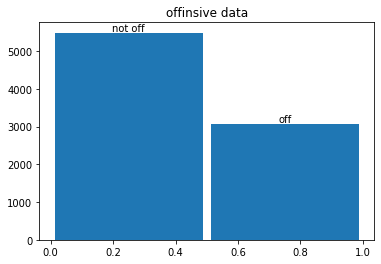

In [4]:
offinsive_data = data.offensive

fig, ax = plt.subplots(1, 1)
ax.hist(offinsive_data, bins=2, rwidth=.95)
ax.set_title("offinsive data")

rects = ax.patches
labels = ['not off', 'off']
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [5]:
len(data.offensive[data.offensive==1]),len(data.offensive[data.offensive==0])

(3065, 5491)

In [7]:
#undersampling
data_off=data[['tweet','offensive']]

off= data_off[data_off.offensive==1]
not_off= data_off[data_off.offensive==0]
off.shape,not_off.shape

((3065, 2), (5491, 2))

In [8]:
not_off=not_off.sample(n=off.shape[0])
off.shape,not_off.shape

((3065, 2), (3065, 2))

In [9]:
undersampled_data = pd.concat([off,not_off])
print(undersampled_data.shape)
undersampled_data.head()

(6130, 2)


,tweet,offensive
0,مستخدم ردينا ع التطنز وجه مبتسم باستهزاء قبض...,1
2,مستخدم روحي لبريده تلقين اشباه كثير بس ماحد زي...,1
8,خلاص اله يزعجكم خلاص وجه بقناع طبي بايع الكليجا,1
9,مستخدم هيلق و جحلط غير كذا مافي وجه بقناع طبي,1
10,مستخدم تعبت ارد على كونت ترا متخلفين ورجعين حت...,1


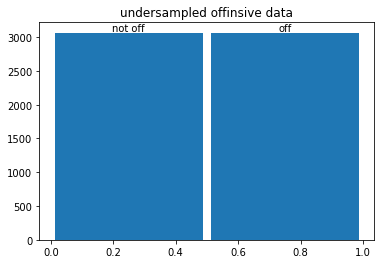

In [10]:
fig, ax = plt.subplots(1, 1)
ax.hist(undersampled_data.offensive, bins=2, rwidth=.95)
ax.set_title("undersampled offinsive data")

rects = ax.patches
labels = ['not off', 'off']
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')
  
# Show plot
plt.show()

In [13]:
#shuffile dataframe
undersampled_data=undersampled_data.sample(frac=1)
undersampled_data.head()

,tweet,offensive
2586,RT مستخدم الرئيس السيسي يزور مقر القيادة الموح...,0
7134,RT مستخدم رتويت وفولو وتعال اريحك ي كلب قرد ب...,1
4602,افهم مقصدي الخوة دمعة ونوح مو خوة الضحكة الجذب...,0
436,مستخدم خوله الكبير وجه بقناع طبي,1
1135,مستخدم حرب شعواء من لجنة المسابقات بالدوري وال...,0


In [15]:
undersampled_data.to_csv('C:/Users/user/NLP/final model GRU blance under_sample dataset/on_undersample_data_offensive.csv',index=False)

In [2]:
data=pd.read_csv('C:/Users/user/NLP/final model GRU blance under_sample dataset/on_undersample_data_offensive.csv')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.tweet, data.offensive, test_size=0.12)
X_train.shape,X_test.shape

((5394,), (736,))

In [14]:
max_length= data.tweet.apply(lambda x: len(str(x).split())).max()
max_length

127

In [15]:
# Using Keras Tokenizer:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
token = Tokenizer()

token.fit_on_texts(list(X_train))

In [16]:
xtrain_seq = token.texts_to_sequences(X_train)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_length)

In [17]:
word_index = token.word_index
vocab_size=len(word_index)+1

In [18]:
embeded_vector_size = 128

model = Sequential()
model.add(Embedding(vocab_size, embeded_vector_size, input_length=max_length,name="embedding"))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 128)          3084672   
                                                                 
 flatten_2 (Flatten)         (None, 16256)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16257     
                                                                 
Total params: 3,100,929
Trainable params: 3,100,929
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.fit(xtrain_pad, y_train, epochs=30,verbose=0)

In [21]:
weights = model.get_layer('embedding').get_weights()[0]
len(weights)

24099

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13)
X_train.shape,X_val.shape

((4692,), (702,))

In [22]:
token = Tokenizer()
token.fit_on_texts(list(X_train) + list(X_val))

xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_val)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_length)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_length)

In [23]:
model = Sequential()
model.add(Embedding(vocab_size,
                     128,
                     weights=[weights],
                     input_length=max_length,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 128)          3084672   
                                                                 
 spatial_dropout1d (SpatialD  (None, 127, 128)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               386100    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 3,471,073
Trainable params: 386,401
Non-trainable params: 3,084,672
_________________________________________________________________


In [24]:
history=model.fit(xtrain_pad, y_train, validation_data=[xvalid_pad,y_val],epochs = 10)

Epoch 1/10
147/147 [==============================] - 142s 954ms/step - loss: 0.6544 - accuracy: 0.6221 - val_loss: 0.6322 - val_accuracy: 0.6538
Epoch 2/10
147/147 [==============================] - 136s 923ms/step - loss: 0.6147 - accuracy: 0.6626 - val_loss: 0.6217 - val_accuracy: 0.6510
Epoch 3/10
147/147 [==============================] - 137s 931ms/step - loss: 0.6097 - accuracy: 0.6662 - val_loss: 0.6109 - val_accuracy: 0.6681
Epoch 4/10
147/147 [==============================] - 137s 935ms/step - loss: 0.6015 - accuracy: 0.6748 - val_loss: 0.6232 - val_accuracy: 0.6709
Epoch 5/10
147/147 [==============================] - 133s 902ms/step - loss: 0.6018 - accuracy: 0.6735 - val_loss: 0.6090 - val_accuracy: 0.6809
Epoch 6/10
147/147 [==============================] - 136s 925ms/step - loss: 0.5932 - accuracy: 0.6867 - val_loss: 0.6238 - val_accuracy: 0.6610
Epoch 7/10
147/147 [==============================] - 136s 928ms/step - loss: 0.5877 - accuracy: 0.6865 - val_loss: 0.6068 -

In [25]:
pickle.dump(X_train, open('X_train', 'wb'))
pickle.dump(y_train, open('y_train', 'wb'))

pickle.dump(X_test, open('X_test', 'wb'))
pickle.dump(y_test, open('y_test', 'wb'))

pickle.dump(X_val, open('X_val', 'wb'))
pickle.dump(y_val, open('y_val', 'wb'))


pickle.dump(xtrain_pad, open('xtrain_pad', 'wb'))
pickle.dump(xvalid_pad, open('xvalid_pad', 'wb'))


In [35]:
model.save('GRU_undersample_data_offensive')

INFO:tensorflow:Assets written to: GRU_undersample_data_offensive\assets


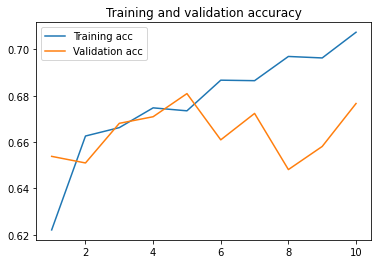

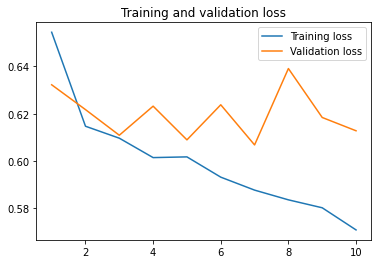

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
xtest_seq = token.texts_to_sequences(X_test)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_length)

In [28]:
model.evaluate(xtest_pad,y_test)

23/23 [==============================] - 4s 157ms/step - loss: 0.6053 - accuracy: 0.6861


[0.6052953600883484, 0.686141312122345]

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report

In [31]:
y_pred=model.predict(xtest_pad)

y_pred = np.around(y_pred)
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[284  81]
 [150 221]]


<AxesSubplot:>

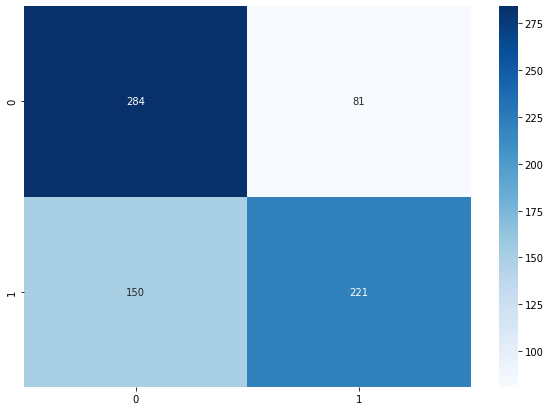

In [32]:
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')

In [34]:
target_names = ['off', 'not']
print(classification_report(y_test,  y_pred,target_names=target_names))

              precision    recall  f1-score   support

         off       0.65      0.78      0.71       365
         not       0.73      0.60      0.66       371

    accuracy                           0.69       736
   macro avg       0.69      0.69      0.68       736
weighted avg       0.69      0.69      0.68       736

